Credit: https://wmathor.com/index.php/archives/1451/

Build Our Mini Tokenizer Here

In [ ]:
class Word2Sequence:
    PAD_TAG = "<PAD>" # Padding Token
    SOS_TAG = "<SOS>" # Start Of Sentence Token
    EOS_TAG = "<EOS>" # End Of Sentence Token
    UNK_TAG = "<UNK>" # Known Token

    PAD = 0
    SOS = 1
    EOS = 2
    UNK = 3
    
    special_tokens = [PAD_TAG, SOS_TAG, EOS_TAG, UNK_TAG]
        
    def __init__(self, custom_dict = None):
        self.dict = {
            self.PAD_TAG : self.PAD,
            self.SOS_TAG : self.SOS,
            self.EOS_TAG : self.EOS,
            self.UNK_TAG : self.UNK
        } if custom_dict == None else custom_dict
        
        self.count = {}

    def fit(self, sentence):
        """save words in sentence to self.dict
        param: sentence: [word1, word2, word3...]
        """
        for word in sentence:
            self.count[word] = self.count.get(word, 0) + 1

    def build_vocab(self, min=5, max=None, max_features=None):
        """
        build self.dict and reverse_dict
        param min:          least occurrance of word to be considered
        param max:          max occurrance of word to be considered
        param max_features: max vocab size for tokenizer
        returns:            
        """
        # Delete words in count whose word frequency is less than min
        if min is not None:
            self.count = {word: value for word,value in self.count.items() if value > min}
        # Delete the value with the number of times greater than max
        if max is not None:
            self.count = {word: value for word,value in self.count.items if value < max}
        # Limit the number of reserved words
        if max_features is not None:
            temp = sorted(self.count.items(), key=lambda x:x[-1], reverse=True)[:max_features]
            self.count = dict(temp)

        for word in self.count:
            if word not in self.special_tokens:
                self.dict[word] = len(self.dict)
        
        # reversed self.dict
        self.reverse_dict = dict(zip(self.dict.values(), self.dict.keys()))
    
    def transform(self, sentence, max_len=None, pad_first=False):
        """
        convert setence to int sequence
        param sentence: [word1, word2...]
        param max_len: int, do padding or truncation
        """
        if max_len is not None: # do padding here
            if pad_first == False:
                if max_len > len(sentence):
                    sentence = sentence + [self.PAD_TAG] * (max_len-len(sentence))
                if max_len < len(sentence):
                    sentence = sentence[:max_len] #truncation
            else:
                if max_len > len(sentence):
                    sentence = [self.PAD_TAG] * (max_len-len(sentence)) + sentence
                if max_len < len(sentence):
                    sentence = sentence[-max_len:] #truncation

        return [self.dict.get(word, self.UNK) for word in sentence]
    
    def inverse_transform(self, indices, is_tensor=False):
        """
        convert int sequences to words
        param indices: [1, 2, 3, 4, 5...]
        """
        if is_tensor == False:
            return [self.reverse_dict.get(idx) for idx in indices]
        
        else:
            
            return [self.reverse_dict.get(idx.item()) for idx in indices]

    def __len__(self):
        return (len(self.dict))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
import random
from nltk.tokenize import WordPunctTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Download dataset here: https://drive.google.com/file/d/12qHUwxEFDONbk-ochQOYfbsZV6W2LsE7/view?usp=sharing

In [ ]:
# read small_en-cn.txt file
data_path = '/content/drive/MyDrive/NLP Curriculum/eng-chin.txt'
df = pd.read_table(data_path,header=None).iloc[:,:]
df = df.drop([2],axis=1)
df.columns=['english','chinese']

input_texts = df.english.values.tolist()#english sentences
target_texts = df.chinese.values.tolist()#chinese sentences

In [ ]:
tk = WordPunctTokenizer()
# limit = 100 # IF model computation is still a burden
# english = [tk.tokenize(sentence.lower()) for sentence in input_texts][:limit]
# chinese = [[x for x in sentence] for sentence in target_texts][:limit]
english = [tk.tokenize(sentence.lower()) for sentence in input_texts]
chinese = [[x for x in sentence] for sentence in target_texts]

In [ ]:
# calculate max_len
max_en_leng = max([len(seq) for seq in english])
# calculate max_len
max_cn_leng = max([len(seq) for seq in chinese])
print(max_en_leng)
print(max_cn_leng)

25
39


1. Since the Max Occurence of English words is 7, input maxlen will be 8
2. Since the Max Occurence of Chinese characters is 9, input maxlen will be 10

In [ ]:
# WHY? Data Structure:
# 1. Encoder Input: [word1, word2, ... + <EOS>]
# 2. Decoder Input: [<SOS> + word1, word2, ...]
# 3. Decoder Output:[word1, word2, ... + <EOS>]

In [ ]:
inp_tk = Word2Sequence()
for words in english:
    inp_tk.fit(words)
inp_tk.build_vocab(min=0, max_features=None)

oup_tk = Word2Sequence()
for words in chinese:
    oup_tk.fit(words)
oup_tk.build_vocab(min=0, max_features=None)

print(f"Total English Words in our input tokenizer: {len(inp_tk.dict)}")
print(f"Total Chinese chars in our output tokenizer: {len(oup_tk.dict)}")

Total English Words in our input tokenizer: 600
Total Chinese chars in our output tokenizer: 667


In [ ]:
class Dataset(Dataset):
  def __init__(self, X, Y, in_tknz, out_tknz, in_maxlen, out_maxlen):
    self.in_maxlen = in_maxlen
    self.out_maxlen = out_maxlen
    
    self.X = X # english sentences
    self.Y = Y # chinese sentences
    
    self.in_tknz = in_tknz # input tokenizer for english
    self.out_tknz = out_tknz # output tokenizer for chinese
  
  def __getitem__(self, idx):
    # -1 because we stil have to concate the <SOS> and <EOS> tokens
    enc_in = self.X[idx][:self.in_maxlen-1]
    enc_in = enc_in + ["<EOS>"]
    
    dec_out = self.Y[idx][:self.out_maxlen-1]
    dec_out = dec_out + ["<EOS>"]
    
    # Convert enc_in, dec_in, dec_out to 1D integers
    enc_in = self.in_tknz.transform(enc_in, max_len=self.in_maxlen, pad_first=False)
    dec_out = self.out_tknz.transform(dec_out, max_len=self.out_maxlen, pad_first=False)

    return enc_in, dec_out

  def __len__(self):
    # Returns number of data in this dataset
    return len(self.X)

# NOTE: collate_fn preprocesses your input from PyTorch Dataset above during PyTorch DataLoader
#       we can convert data into Long Tensors Here
def collate_fn(batch):
    '''
    param batch: ([enc_in, dec_out]， [enc_in, dec_out], output of getitem...)
    '''
    # unpack values
    enc_in, dec_out = list(zip(*batch))
    # Return tensor type
    return torch.LongTensor(enc_in), torch.LongTensor(dec_out)

def get_dataloader(dataset, batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader

In [ ]:
# NOTE: For Structure of Encoder Inputs, they can all be either (assume all have same maxlen): 
# 1. <SOS>, word1, word2, word3, ..., <EOS>
# 2. word1, word2, word3, ..., <EOS> 
# 3. word1, word2, word3, ...

# NOTE: But Decoder In and Out structures should always look like this (assume all have same maxlen):
# Decoder Input: <SOS>, word1, word2, word3, ...
# Decoder Output: word1, word2, word3, ..., <EOS> 

In [ ]:
eng_maxlen = 26 # 25 + 1(<EOS> token)
chin_maxlen = 40 # 39 + 1(<EOS> token or <SOS> token)
batch_size = 1 # Seq2Seq is very ram consuming, we have to keep batch_size low

# Get PyTorch Dataset
dataset = Dataset(
    X = english,
    Y = chinese,
    in_tknz = inp_tk, out_tknz = oup_tk,
    in_maxlen = eng_maxlen, out_maxlen = chin_maxlen
)
# Get PyTorch DataLoader
dataloader = get_dataloader(dataset, batch_size)

In [ ]:
# Seq2Seq Paarameters
in_maxlen = 26 # 25 + 1(<EOS> token)
out_maxlen = 40 # 39 + 1(<EOS> token or <SOS> token)
n_hidden = 384 # number of "neurons" per layer
d_model = 64 # number of embedding dimensions to represent each word
enc_n_class = len(inp_tk.dict) # OR... vocab size of englisth -> 600
dec_n_class = len(oup_tk.dict) # OR... vocab size of chinese -> 667
batch_size = 1

Seq2Seq is really a CLASSIFICATION problem, with num classes of output vocab size to predict

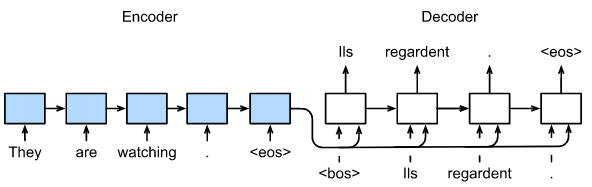

Note: GRU is a sister variant of LSTM, just that GRU only has one h_0 while LSTM has both cell and h_0

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src): 
        '''
        src = [src_len, batch_size]
        '''
        src = src.transpose(0, 1) # src = [batch_size, src_len]
        embedded = self.dropout(self.embedding(src)).transpose(0, 1) # embedded = [src_len, batch_size, emb_dim]
        
        # enc_output = [src_len, batch_size, hid_dim]
        # enc_hidden = [n_layers, batch_size, hid_dim]
        enc_output, enc_hidden = self.rnn(embedded) # if h_0 is not give, it will be set 0 acquiescently

        # enc_hidden is stacked [forward_1, forward_2, forward_3, ...]
        # enc_output are always from the last layer
        
        # enc_hidden [-1, :, : ] is the last of the backwards RNN
        
        # initial decoder hidden is final hidden state
        # encoder RNNs fed through a linear layer
        # s = [batch_size, dec_hid_dim]
        s = torch.tanh(enc_hidden[-1,:,:])
        
        return enc_output, s

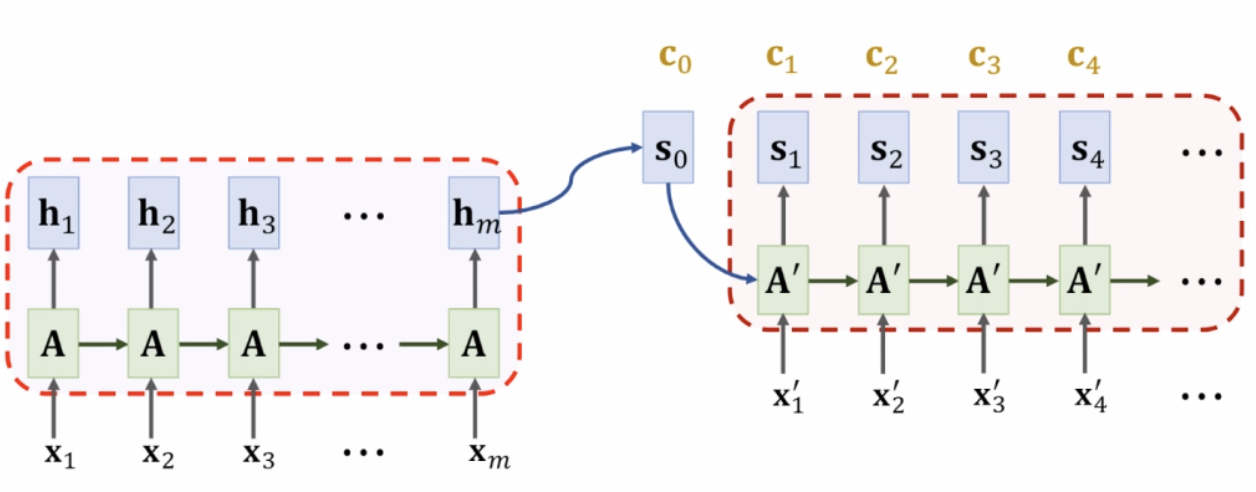

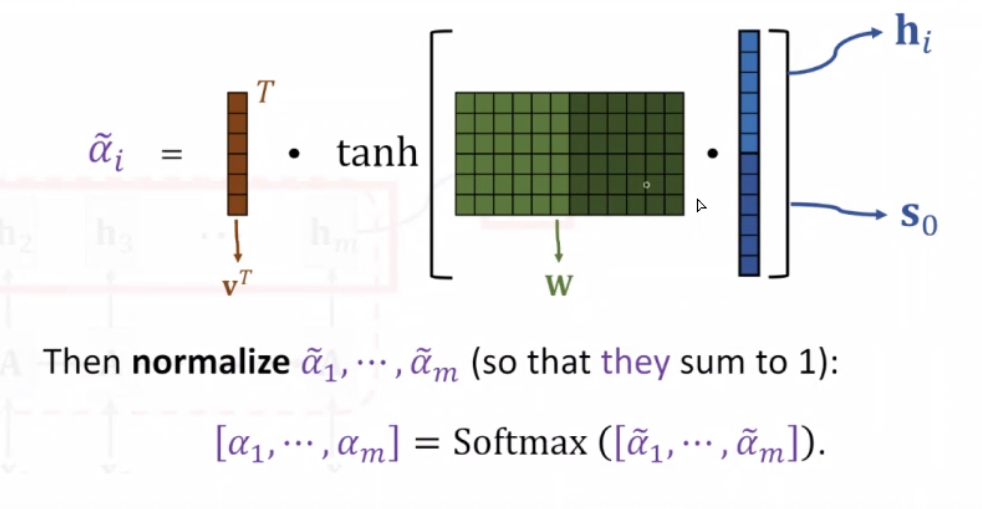

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim,
                 bidirectional=False):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim) + dec_hid_dim, dec_hid_dim, bias=False)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, s, enc_output):
        
        # s = [batch_size, dec_hid_dim]
        # enc_output = [src_len, batch_size, enc_hid_dim]
        
        batch_size = enc_output.shape[1]
        src_len = enc_output.shape[0]
        
        # repeat decoder hidden state src_len times
        # s = [batch_size, src_len, dec_hid_dim]
        # enc_output = [batch_size, src_len, enc_hid_dim]
        s = s.unsqueeze(1).repeat(1, src_len, 1)
        enc_output = enc_output.transpose(0, 1)
        
        # energy = [batch_size, src_len, dec_hid_dim]
        energy = torch.tanh(self.attn(torch.cat((s, enc_output), dim = 2)))
        
        # attention = [batch_size, src_len]
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention,
                 bidirectional=False):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, dec_input, s, enc_output):
             
        # dec_input = [batch_size]
        # s = [batch_size, dec_hid_dim]
        # enc_output = [src_len, batch_size, enc_hid_dim]
        
        dec_input = dec_input.unsqueeze(1) # dec_input = [batch_size, 1]
        
        embedded = self.dropout(self.embedding(dec_input)).transpose(0, 1) # embedded = [1, batch_size, emb_dim]
        
        # a = [batch_size, 1, src_len]  
        a = self.attention(s, enc_output).unsqueeze(1)
        
        # enc_output = [batch_size, src_len, enc_hid_dim]
        enc_output = enc_output.transpose(0, 1)

        # c = [1, batch_size, enc_hid_dim]
        c = torch.bmm(a, enc_output).transpose(0, 1)

        # rnn_input = [1, batch_size, enc_hid_dim + emb_dim]
        rnn_input = torch.cat((embedded, c), dim = 2)
            
        # dec_output = [src_len(=1), batch_size, dec_hid_dim]
        # dec_hidden = [n_layers, batch_size, dec_hid_dim]
        dec_output, dec_hidden = self.rnn(rnn_input, s.unsqueeze(0))
        
        # embedded = [batch_size, emb_dim]
        # dec_output = [batch_size, dec_hid_dim]
        # c = [batch_size, enc_hid_dim]
        embedded = embedded.squeeze(0)
        dec_output = dec_output.squeeze(0)
        c = c.squeeze(0)
        
        # pred = [batch_size, output_dim]
        pred = self.fc_out(torch.cat((dec_output, c, embedded), dim = 1))
        
        return pred, dec_hidden.squeeze(0)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src_len, batch_size]
        # trg = [trg_len, batch_size]
        # teacher_forcing_ratio is probability to use teacher forcing
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # enc_output is all hidden states of the input sequence, back and forwards
        # s is the final forward and backward hidden states, passed through a linear layer
        enc_output, s = self.encoder(src)
                
        # first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        
        for t in range(1, trg_len):
            
            # insert dec_input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            dec_output, s = self.decoder(dec_input, s, enc_output)
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = dec_output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions
            top1 = dec_output.argmax(1) 
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            dec_input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
INPUT_DIM = len(inp_tk.dict) # vocab_size for english
OUTPUT_DIM = len(oup_tk.dict) # vocab_size for chinese
ENC_EMB_DIM = 384
DEC_EMB_DIM = 384
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)
# # NOTE: Uncomment this if loading pretrained model
# model.load_state_dict(torch.load("seq2seq.pt", map_location=device))
criterion = nn.CrossEntropyLoss(ignore_index = inp_tk.dict["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(model, dataloader, optimizer, criterion):
    model.train()    
    epoch_loss = 0
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader.dataset)/1):
        src = batch[0].permute(1,0) # src = [src_len, batch_size]
        trg = batch[2].permute(1,0) # trg = [trg_len, batch_size]
        src, trg = src.to(device), trg.to(device)
        # pred = [trg_len, batch_size, pred_dim]
        pred = model(src, trg)
        
        pred_dim = pred.shape[-1]
        
        # trg = [(trg len - 1) * batch size]
        # pred = [(trg len - 1) * batch size, pred_dim]
        trg = trg[1:].view(-1)
        pred = pred[1:].view(-1, pred_dim)
        
        loss = criterion(pred, trg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
  
    return epoch_loss / len(dataloader.dataset)

In [ ]:
loss_records = []
for epoch in range(100):
    train_loss = train(model, dataloader, optimizer, criterion)
    loss_records.append(train_loss)
    torch.save(model.state_dict(), 'seq2seq.pt')
    print(f'\tEpoch: {epoch} Train Loss: {train_loss:.3f}')

100%|██████████| 99/99.0 [00:08<00:00, 12.19it/s]


	Epoch: 0 Train Loss: 6.134


100%|██████████| 99/99.0 [00:08<00:00, 11.58it/s]


	Epoch: 1 Train Loss: 5.413


100%|██████████| 99/99.0 [00:08<00:00, 12.03it/s]


	Epoch: 2 Train Loss: 4.879


100%|██████████| 99/99.0 [00:08<00:00, 12.36it/s]


	Epoch: 3 Train Loss: 4.188


100%|██████████| 99/99.0 [00:08<00:00, 11.95it/s]


	Epoch: 4 Train Loss: 3.559


100%|██████████| 99/99.0 [00:08<00:00, 12.16it/s]


	Epoch: 5 Train Loss: 3.075


100%|██████████| 99/99.0 [00:08<00:00, 12.00it/s]


	Epoch: 6 Train Loss: 2.503


100%|██████████| 99/99.0 [00:08<00:00, 12.08it/s]


	Epoch: 7 Train Loss: 2.181


100%|██████████| 99/99.0 [00:08<00:00, 12.17it/s]


	Epoch: 8 Train Loss: 1.747


100%|██████████| 99/99.0 [00:09<00:00, 11.00it/s]


	Epoch: 9 Train Loss: 1.489


100%|██████████| 99/99.0 [00:08<00:00, 11.30it/s]


	Epoch: 10 Train Loss: 1.326


100%|██████████| 99/99.0 [00:08<00:00, 12.31it/s]


	Epoch: 11 Train Loss: 1.222


100%|██████████| 99/99.0 [00:07<00:00, 12.42it/s]


	Epoch: 12 Train Loss: 1.102


100%|██████████| 99/99.0 [00:08<00:00, 11.98it/s]


	Epoch: 13 Train Loss: 0.979


100%|██████████| 99/99.0 [00:07<00:00, 12.48it/s]


	Epoch: 14 Train Loss: 0.941


100%|██████████| 99/99.0 [00:08<00:00, 12.25it/s]


	Epoch: 15 Train Loss: 0.825


100%|██████████| 99/99.0 [00:07<00:00, 12.43it/s]


	Epoch: 16 Train Loss: 0.771


100%|██████████| 99/99.0 [00:08<00:00, 12.35it/s]


	Epoch: 17 Train Loss: 0.741


100%|██████████| 99/99.0 [00:08<00:00, 12.00it/s]


	Epoch: 18 Train Loss: 0.687


100%|██████████| 99/99.0 [00:07<00:00, 12.50it/s]


	Epoch: 19 Train Loss: 0.601


100%|██████████| 99/99.0 [00:08<00:00, 11.54it/s]


	Epoch: 20 Train Loss: 0.604


100%|██████████| 99/99.0 [00:08<00:00, 11.52it/s]


	Epoch: 21 Train Loss: 0.574


100%|██████████| 99/99.0 [00:08<00:00, 12.13it/s]


	Epoch: 22 Train Loss: 0.561


100%|██████████| 99/99.0 [00:07<00:00, 12.43it/s]


	Epoch: 23 Train Loss: 0.580


100%|██████████| 99/99.0 [00:08<00:00, 12.34it/s]


	Epoch: 24 Train Loss: 0.537


100%|██████████| 99/99.0 [00:07<00:00, 12.41it/s]


	Epoch: 25 Train Loss: 0.512


100%|██████████| 99/99.0 [00:08<00:00, 11.98it/s]


	Epoch: 26 Train Loss: 0.489


100%|██████████| 99/99.0 [00:07<00:00, 12.56it/s]


	Epoch: 27 Train Loss: 0.433


100%|██████████| 99/99.0 [00:07<00:00, 12.61it/s]


	Epoch: 28 Train Loss: 0.416


100%|██████████| 99/99.0 [00:07<00:00, 12.66it/s]


	Epoch: 29 Train Loss: 0.459


100%|██████████| 99/99.0 [00:08<00:00, 12.13it/s]


	Epoch: 30 Train Loss: 0.501


100%|██████████| 99/99.0 [00:08<00:00, 12.17it/s]


	Epoch: 31 Train Loss: 0.435


100%|██████████| 99/99.0 [00:08<00:00, 12.26it/s]


	Epoch: 32 Train Loss: 0.457


100%|██████████| 99/99.0 [00:08<00:00, 12.00it/s]


	Epoch: 33 Train Loss: 0.448


100%|██████████| 99/99.0 [00:08<00:00, 12.30it/s]


	Epoch: 34 Train Loss: 0.418


100%|██████████| 99/99.0 [00:07<00:00, 12.75it/s]


	Epoch: 35 Train Loss: 0.448


100%|██████████| 99/99.0 [00:08<00:00, 12.26it/s]


	Epoch: 36 Train Loss: 0.426


100%|██████████| 99/99.0 [00:07<00:00, 12.66it/s]


	Epoch: 37 Train Loss: 0.579


100%|██████████| 99/99.0 [00:07<00:00, 12.90it/s]


	Epoch: 38 Train Loss: 0.522


100%|██████████| 99/99.0 [00:07<00:00, 12.63it/s]


	Epoch: 39 Train Loss: 0.499


100%|██████████| 99/99.0 [00:07<00:00, 12.62it/s]


	Epoch: 40 Train Loss: 0.541


100%|██████████| 99/99.0 [00:07<00:00, 12.53it/s]


	Epoch: 41 Train Loss: 0.462


100%|██████████| 99/99.0 [00:07<00:00, 12.53it/s]


	Epoch: 42 Train Loss: 0.520


100%|██████████| 99/99.0 [00:07<00:00, 12.72it/s]


	Epoch: 43 Train Loss: 0.531


100%|██████████| 99/99.0 [00:07<00:00, 12.88it/s]


	Epoch: 44 Train Loss: 0.494


100%|██████████| 99/99.0 [00:07<00:00, 12.62it/s]


	Epoch: 45 Train Loss: 0.444


100%|██████████| 99/99.0 [00:08<00:00, 12.34it/s]


	Epoch: 46 Train Loss: 0.456


100%|██████████| 99/99.0 [00:07<00:00, 12.79it/s]


	Epoch: 47 Train Loss: 0.415


100%|██████████| 99/99.0 [00:08<00:00, 11.97it/s]


	Epoch: 48 Train Loss: 0.407


100%|██████████| 99/99.0 [00:08<00:00, 11.61it/s]


	Epoch: 49 Train Loss: 0.388


100%|██████████| 99/99.0 [00:08<00:00, 11.64it/s]


	Epoch: 50 Train Loss: 0.384


100%|██████████| 99/99.0 [00:08<00:00, 12.06it/s]


	Epoch: 51 Train Loss: 0.426


100%|██████████| 99/99.0 [00:07<00:00, 12.65it/s]


	Epoch: 52 Train Loss: 0.422


100%|██████████| 99/99.0 [00:07<00:00, 12.73it/s]


	Epoch: 53 Train Loss: 0.456


100%|██████████| 99/99.0 [00:07<00:00, 12.46it/s]


	Epoch: 54 Train Loss: 0.451


100%|██████████| 99/99.0 [00:07<00:00, 12.72it/s]


	Epoch: 55 Train Loss: 0.422


100%|██████████| 99/99.0 [00:07<00:00, 12.46it/s]


	Epoch: 56 Train Loss: 0.392


100%|██████████| 99/99.0 [00:08<00:00, 12.36it/s]


	Epoch: 57 Train Loss: 0.377


100%|██████████| 99/99.0 [00:07<00:00, 12.64it/s]


	Epoch: 58 Train Loss: 0.375


100%|██████████| 99/99.0 [00:07<00:00, 12.82it/s]


	Epoch: 59 Train Loss: 0.388


100%|██████████| 99/99.0 [00:08<00:00, 12.05it/s]


	Epoch: 60 Train Loss: 0.444


100%|██████████| 99/99.0 [00:08<00:00, 12.23it/s]


	Epoch: 61 Train Loss: 0.449


100%|██████████| 99/99.0 [00:08<00:00, 12.28it/s]


	Epoch: 62 Train Loss: 0.426


100%|██████████| 99/99.0 [00:07<00:00, 12.59it/s]


	Epoch: 63 Train Loss: 0.425


100%|██████████| 99/99.0 [00:08<00:00, 11.65it/s]


	Epoch: 64 Train Loss: 0.465


100%|██████████| 99/99.0 [00:07<00:00, 12.76it/s]


	Epoch: 65 Train Loss: 0.452


100%|██████████| 99/99.0 [00:07<00:00, 12.62it/s]


	Epoch: 66 Train Loss: 0.393


100%|██████████| 99/99.0 [00:08<00:00, 11.99it/s]


	Epoch: 67 Train Loss: 0.395


100%|██████████| 99/99.0 [00:08<00:00, 12.26it/s]


	Epoch: 68 Train Loss: 0.360


100%|██████████| 99/99.0 [00:07<00:00, 12.43it/s]


	Epoch: 69 Train Loss: 0.374


100%|██████████| 99/99.0 [00:08<00:00, 11.93it/s]


	Epoch: 70 Train Loss: 0.427


100%|██████████| 99/99.0 [00:07<00:00, 12.91it/s]


	Epoch: 71 Train Loss: 0.439


100%|██████████| 99/99.0 [00:08<00:00, 12.04it/s]


	Epoch: 72 Train Loss: 0.491


100%|██████████| 99/99.0 [00:07<00:00, 12.51it/s]


	Epoch: 73 Train Loss: 0.484


100%|██████████| 99/99.0 [00:07<00:00, 12.52it/s]


	Epoch: 74 Train Loss: 0.426


100%|██████████| 99/99.0 [00:08<00:00, 11.90it/s]


	Epoch: 75 Train Loss: 0.503


100%|██████████| 99/99.0 [00:08<00:00, 11.68it/s]


	Epoch: 76 Train Loss: 0.454


100%|██████████| 99/99.0 [00:07<00:00, 12.57it/s]


	Epoch: 77 Train Loss: 0.450


100%|██████████| 99/99.0 [00:07<00:00, 12.40it/s]


	Epoch: 78 Train Loss: 0.507


100%|██████████| 99/99.0 [00:07<00:00, 12.60it/s]


	Epoch: 79 Train Loss: 0.490


100%|██████████| 99/99.0 [00:07<00:00, 12.49it/s]


	Epoch: 80 Train Loss: 0.465


100%|██████████| 99/99.0 [00:08<00:00, 11.88it/s]


	Epoch: 81 Train Loss: 0.408


100%|██████████| 99/99.0 [00:08<00:00, 12.08it/s]


	Epoch: 82 Train Loss: 0.387


100%|██████████| 99/99.0 [00:08<00:00, 12.11it/s]


	Epoch: 83 Train Loss: 0.342


100%|██████████| 99/99.0 [00:08<00:00, 11.92it/s]


	Epoch: 84 Train Loss: 0.370


100%|██████████| 99/99.0 [00:08<00:00, 12.20it/s]


	Epoch: 85 Train Loss: 0.481


100%|██████████| 99/99.0 [00:08<00:00, 11.80it/s]


	Epoch: 86 Train Loss: 0.460


100%|██████████| 99/99.0 [00:08<00:00, 12.31it/s]


	Epoch: 87 Train Loss: 0.418


100%|██████████| 99/99.0 [00:08<00:00, 12.32it/s]


	Epoch: 88 Train Loss: 0.419


100%|██████████| 99/99.0 [00:07<00:00, 12.55it/s]


	Epoch: 89 Train Loss: 0.434


100%|██████████| 99/99.0 [00:08<00:00, 12.28it/s]


	Epoch: 90 Train Loss: 0.531


100%|██████████| 99/99.0 [00:07<00:00, 12.67it/s]


	Epoch: 91 Train Loss: 0.456


100%|██████████| 99/99.0 [00:07<00:00, 12.42it/s]


	Epoch: 92 Train Loss: 0.454


100%|██████████| 99/99.0 [00:07<00:00, 13.00it/s]


	Epoch: 93 Train Loss: 0.470


100%|██████████| 99/99.0 [00:07<00:00, 13.00it/s]


	Epoch: 94 Train Loss: 0.375


100%|██████████| 99/99.0 [00:07<00:00, 12.69it/s]


	Epoch: 95 Train Loss: 0.423


100%|██████████| 99/99.0 [00:07<00:00, 12.64it/s]


	Epoch: 96 Train Loss: 0.393


100%|██████████| 99/99.0 [00:07<00:00, 13.18it/s]


	Epoch: 97 Train Loss: 0.403


100%|██████████| 99/99.0 [00:07<00:00, 12.51it/s]


	Epoch: 98 Train Loss: 0.381


100%|██████████| 99/99.0 [00:07<00:00, 13.02it/s]

	Epoch: 99 Train Loss: 0.411


In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points): # Helper function for showing our plots
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

<Figure size 432x288 with 0 Axes>

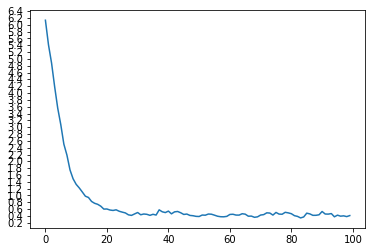

In [ ]:
showPlot(loss_records)

In [ ]:
def translate(eng_sent, model, device):
    eng_sent = tk.tokenize(eng_sent.lower()) + ["<EOS>"]
    eng_sent = inp_tk.transform(eng_sent, max_len=26, pad_first=False)
    dec_in = (["<SOS>"] + ["<PAD>"]*40)[:40]
    dec_in = oup_tk.transform(dec_in, max_len=40, pad_first=False)
    eng_sent, dec_in = torch.LongTensor(eng_sent), torch.LongTensor(dec_in)
    src = eng_sent.unsqueeze(1)
    trg = dec_in.unsqueeze(1)
    src, trg = src.to(device), trg.to(device)
    pred = model(src, trg, teacher_forcing_ratio=-1) # avoid teacher_forcing_ratio by setting negative
    pred_dim = pred.shape[-1]
    pred = pred[0:].view(-1, pred_dim)
    return pred

In [ ]:
import random
eng_sents = random.sample(input_texts, 5)
for sent in eng_sents:
  pred = translate(sent, model, device)
  pred = [pred.topk(1)[1].item() for pred in pred]
  print(sent)
  print("".join([word for word in oup_tk.inverse_transform(pred) if word != "<EOS>"and word != "<PAD>"]))
  print("\n")

Mary tied an apron around her waist and then took the turkey out of the oven.
里钱不能把围裙围的，然后把烤鸡从炉子里拿出来。


If it's at all possible, I'd like you to take part in the next meeting.
可能的話, 我希望你參加下一次的會議。議。的話可能。


It was not until I had a baby myself that I knew what mother's love is.
自己买了孩子我才明白了什么是母爱。。


A person views things differently according to whether they are rich or poor.
事情的看法不同是依據他們是富有還是貧窮。窮。


After asking for my key at the front desk, I took the elevator to my floor.
櫃檯拿到櫃檯拿到鑰匙，然後就乘電梯去了我房間的樓層。間。間


